# Get data

In [1]:
# from algorithms.data.vn30f1m_algotrade import get_data

# get_data('a.csv', start_year=2021, start_month=6)

In [2]:
from algorithms import macd, rsi, linear, std, deviation2std
from algorithms.stop.middle import tradingstop
from algorithms.stop.expiration_vn30f1m import expiration
from algorithms.tools.plot_entry import plot_entry_points
from algorithms.tools.analysis import analysis
from algorithms.data.vn30f1m_algotrade import get_dataframe
import pandas as pd
import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = get_dataframe('a.csv', resample_time='30min')
df_train = df[df.index.year < 2023]
df_test = df[df.index.year >= 2023]

/home/kat/.conda/envs/aivi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Close price

<Axes: xlabel='datetime'>

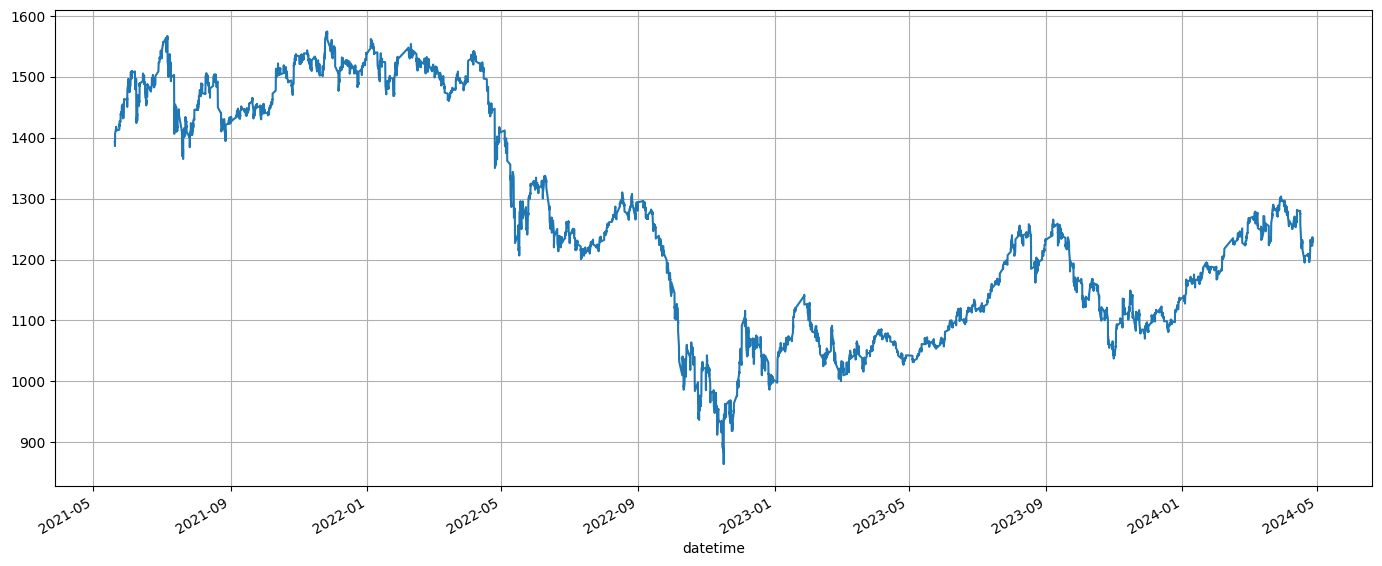

In [3]:
df['Close'].plot(figsize=(17,7), grid=True)

## Strategy

- Definition
    - Slopel1: linear line of Close value (by taking *n* continuous points and find the linear line through them all)
    - MACDhvm1: MACD histogram velocity (by taking the difference between the current value and the previous value of MACD histogram)
    - MACDvm1: MACD velocity (taking the difference between current and previous value of MACD value, MACD line)
    - MACDm1: MACD value
- Long
    - MACDm1 is larger than *threshold*
    - MACDvm1 is larger than 0 (MACD line is going up)
    - MACDhvm1 is larger than 0 (MACD histogram is going up)
    - Slopl1 is larger than 0 (Close price seem to start/continue to increase)
- Short
    - MACDm1 is smaller than *threshold*
    - MACDvm1 is smaller than 0 (MACD line is going down)
    - MACDhvm1 is smaller than 0 (MACD histogram is going down)
    - Slopl1 is smaller than 0 (Close price seem to start/continue to decrease)

In [4]:
@tradingstop
@expiration
def macd_linear(trading_df: pd.DataFrame, **kwargs):
    threshold = kwargs.get('threshold_macd')
    df = linear(trading_df, name='l1', **kwargs)
    df = macd(df, name='m1', **kwargs)

    df.loc[(df['Slopel1'] > 0) & (df['MACDhvm1'] > 0) & (df['MACDvm1'] > 0) & (df['MACDm1'] > -threshold), 'Position'] = 1
    df.loc[(df['Slopel1'] < 0) & (df['MACDhvm1'] < 0) & (df['MACDvm1'] < 0) & (df['MACDm1'] < threshold), 'Position'] = -1

    return df

# Find parameters for algorithm

In [5]:
def objective(trial):
    param = {
        'alpha': trial.suggest_float('alpha', 0.75, 0.99, step=0.01),
        'beta': trial.suggest_float('beta', 0.5, 5, step=0.5),
        'threshold_macd': trial.suggest_float('threshold_macd', 0.5, 50, step=0.1),
        'windowl1': trial.suggest_int('windowl1', 3, 50),
        'fastm1': trial.suggest_int('fastm1', 5, 50),
        'slowm1': trial.suggest_int('slowm1', 5, 50),
        'signalm1': trial.suggest_int('signalm1', 5, 50),
        'diff_range1m': trial.suggest_int('diff_range1m', 1, 5),
    }

    try:
        trading = macd_linear(df_train, **param)
        backtestinfo = analysis(trading, visual=False)

        return backtestinfo['sharpe_after_fee']-backtestinfo['mdd']-backtestinfo['number_of_trade']*0.01
    except:
        return -100

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-29 13:52:28,563] A new study created in memory with name: no-name-96162507-05a6-4943-9e20-4bc9a83887d0
/home/kat/HCMUS/.Self/QuantTrading/algorithms/stop/middle.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df.loc[:, 'Position'] = np.nan
[I 2024-04-29 13:52:28,732] Trial 0 finished with value: -103.69825589883747 and parameters: {'alpha': 0.88, 'beta': 2.0, 'threshold_macd': 49.2, 'windowl1': 12, 'fastm1': 36, 'slowm1': 7, 'signalm1': 13, 'diff_range1m': 4}. Best is trial 0 with value: -103.69825589883747.
[I 2024-04-29 13:52:28,877] Trial 1 finished with value: -79.18857834469186 and parameters: {'alpha': 0.88, 'beta': 1.5, 'threshold_macd': 27.700000000000003, 'windowl1': 44, 'fastm1': 25, 'slowm1': 47, 'signalm1': 6, '

In [6]:
best_params = {'alpha': 0.86,
 'beta': 1.0,
 'threshold_macd': 4.4,
 'windowl1': 18,
 'fastm1': 24,
 'slowm1': 10,
 'signalm1': 9,
 'diff_range1m': 4}
best_params = study.best_params
best_params

{'alpha': 0.86,
 'beta': 0.5,
 'threshold_macd': 17.5,
 'windowl1': 24,
 'fastm1': 14,
 'slowm1': 19,
 'signalm1': 9,
 'diff_range1m': 4}

# Test on training data

mdd: 49.69999999999982
sharpe: 2.1212768113877143
sharpe_after_fee: 1.933649842851311
number_of_trade: 456


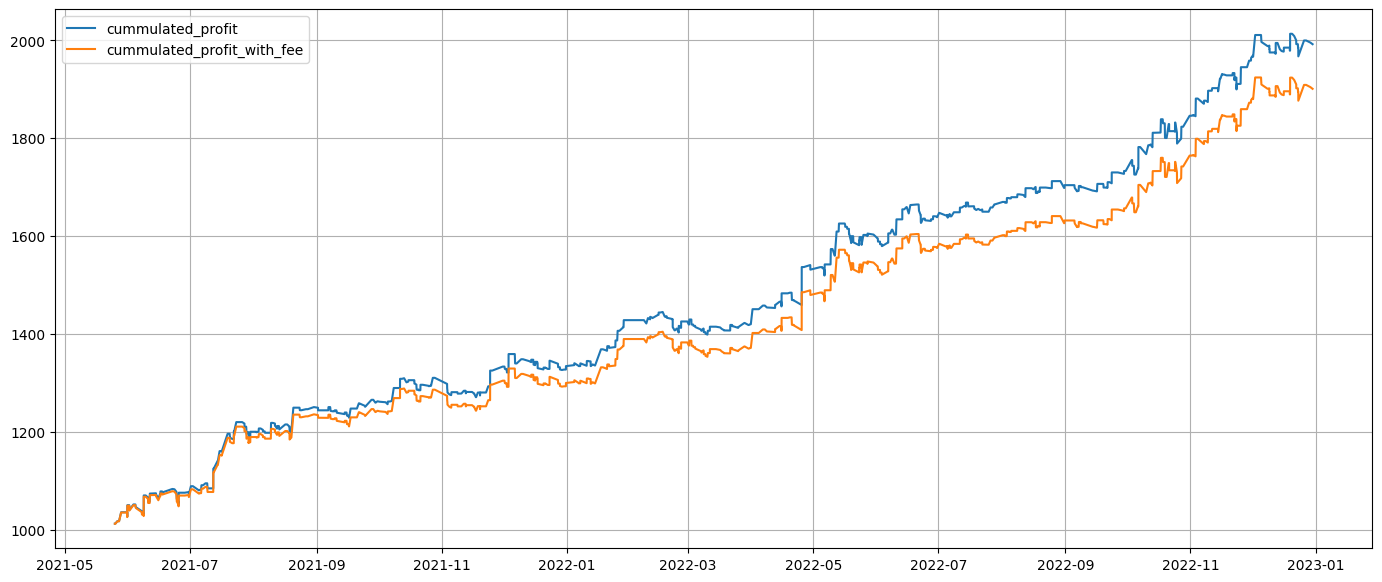

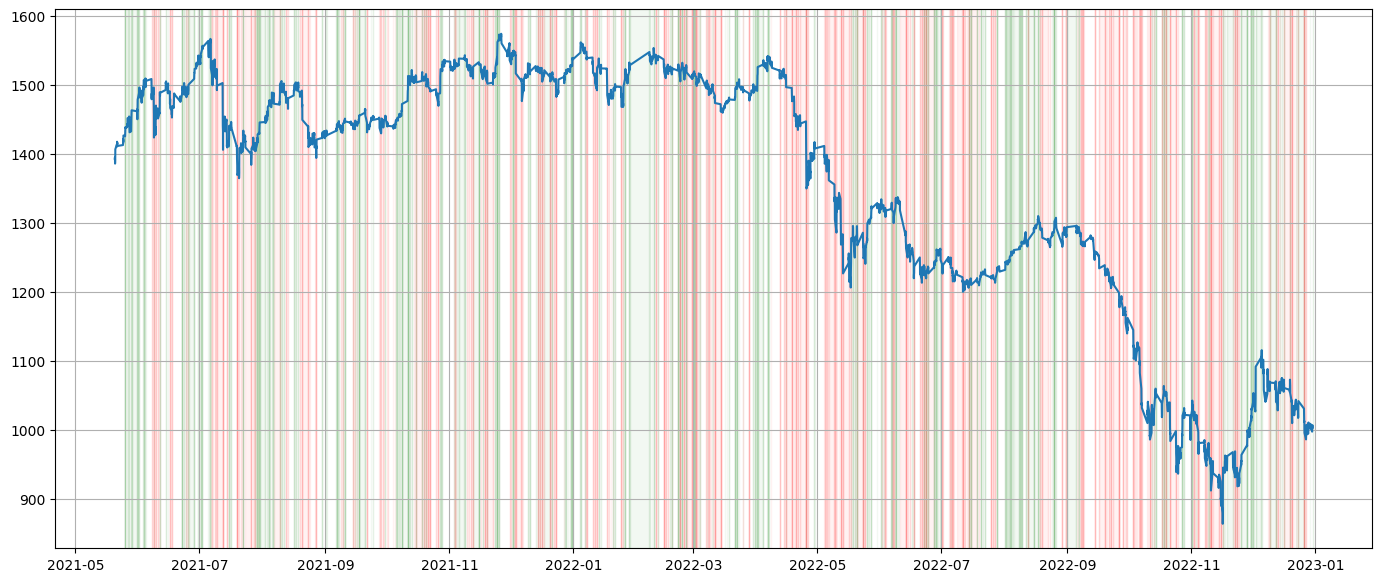

In [7]:
trading = macd_linear(df_train, **best_params)
output = analysis(trading)
plot_entry_points(trading, reset_index=False, ploting_params=['Close'])

# Test on test data

/home/kat/HCMUS/.Self/QuantTrading/algorithms/stop/middle.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df.loc[:, 'Position'] = np.nan


mdd: 43.30000000000064
sharpe: 2.2944415450153546
sharpe_after_fee: 2.016104090511471
number_of_trade: 350


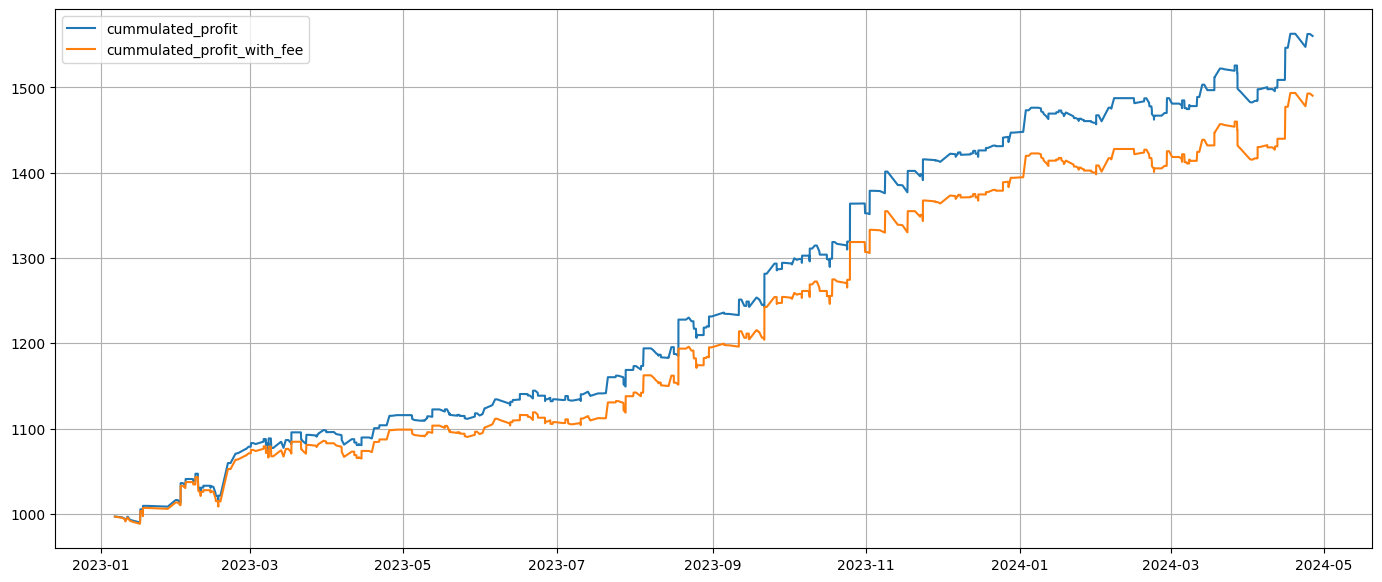

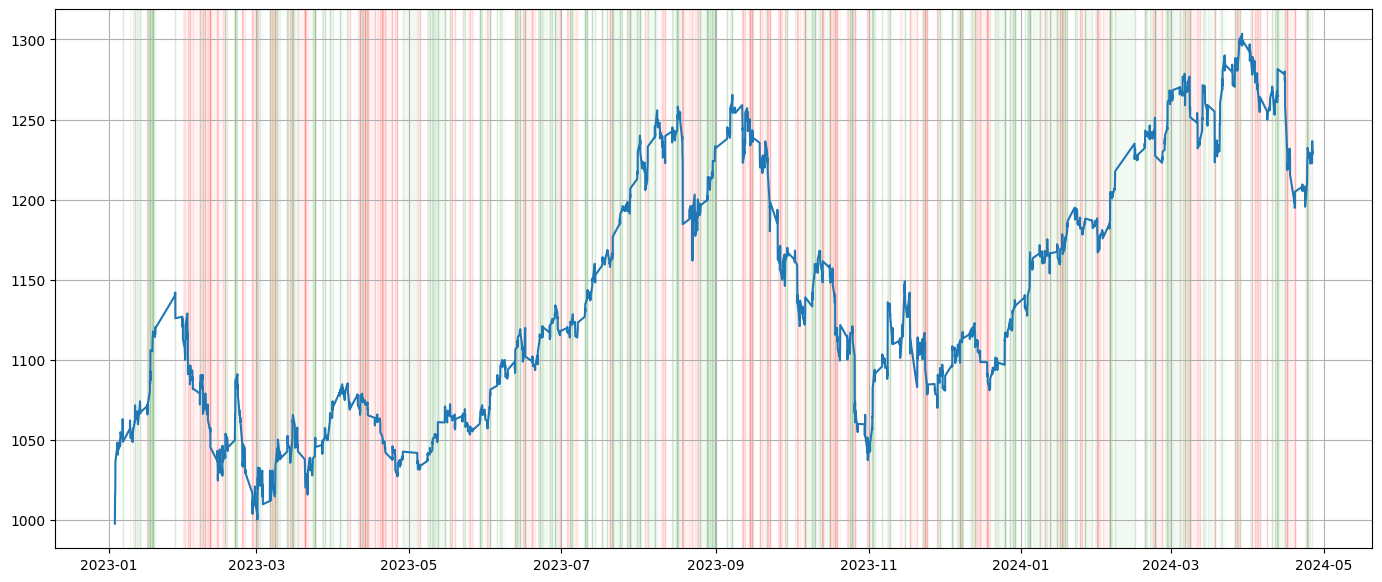

In [8]:
trading = macd_linear(df_test, **best_params)
analysis(trading)
plot_entry_points(trading, reset_index=False, ploting_params=['Close'])

# Start Live-trading

In [9]:
from algorithms.live.algotrade import LiveAlgoTrading
from algorithms import macd, rsi, linear, std, deviation2std
from algorithms.stop.middle import tradingstop
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@LiveAlgoTrading(
    history_save_file = './trading_history.csv',
    past_trading_data_file = './a.csv', # Remember to include past data of trading
    dataframe_resample_time = '30min',
    number_of_used_trading_data = 70,
    trading_waiting_time = 30000,
    # channel = 'VN30F1M04', # Uncomment to test
    )
@tradingstop
def macd_linear(trading_df: pd.DataFrame, **kwargs):
    threshold = kwargs.get('threshold_macd')
    df = linear(trading_df, name='l1', **kwargs)
    df = macd(df, name='m1', **kwargs)

    df.loc[(df['Slopel1'] > 0) & (df['MACDhvm1'] > 0) & (df['MACDvm1'] > 0) & (df['MACDm1'] > -threshold), 'Position'] = 1
    df.loc[(df['Slopel1'] < 0) & (df['MACDhvm1'] < 0) & (df['MACDvm1'] < 0) & (df['MACDm1'] < threshold), 'Position'] = -1

    return df

macd_linear(**best_params)

# Analysis live trading

In [10]:
import pandas as pd
from algorithms.tools.analysis import analysis

live_trading_df = pd.read_csv('./trading_history.csv')
analysis(live_trading_df, position='Position', price='Close')